# 04 Example: Nonlinear Frame Analysis and Cross-Sectional Analysis
___

## Setup
import all the needed libraries and files.

In [1]:
import numpy as np

from Structure import *
from Material import *
from Solver import *

from Plotting_Functions import *

## Generate the Geometry and the corresponding mesh

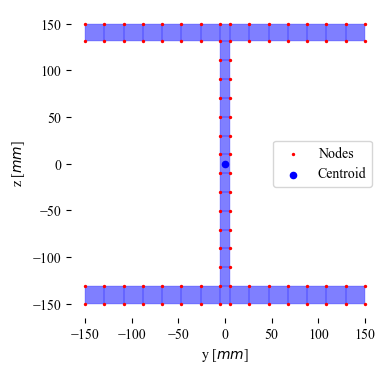

╒════════════════════╤═══════════════╕
│ Mesh Type          │ quadrilateral │
├────────────────────┼───────────────┤
│ Number of elements │ 43            │
├────────────────────┼───────────────┤
│ Number of nodes    │ 88            │
├────────────────────┼───────────────┤
│ Cross Section Area │ 14282.00      │
╘════════════════════╧═══════════════╛
╒══════════════════════════╤══════════╤══════════╕
│                          │ y        │ z        │
╞══════════════════════════╪══════════╪══════════╡
│ Centroid [mm]            │ 0.00     │ 0.00     │
├──────────────────────────┼──────────┼──────────┤
│ Moment of inertia [mm^4] │ 2.42e+08 │ 8.55e+07 │
╘══════════════════════════╧══════════╧══════════╛


In [2]:
# Initalize the geometry of the column
HEB_300 = H_beam(web_width     =  11.0,
                 web_height    = 262.0,
                 flange_width  = 300.0,
                 flange_height =  19.0)

# Create the mesh of the column
column = Mesh(HEB_300, mesh_type="quadrilateral", mesh_size=20)

# Print and plot the mesh of the column
column.plot()
column.print()

## Structure
Initialize the structure. For a frame, one has to define the columns and the beams geometry, the number of storeys, their width and height as well as the DOF where nodal loads will be applied and their value. 

Each node has 6 DOFs (counting starts from 0). The nodes start counting on the bottom left (0), then bottom right (1), then one storey up on the left side (2) and so on. To apply a lateral load we need the first DOF (global x-direction) of the node number 2, so therefore DOF n*6 = 2*6 = 12.

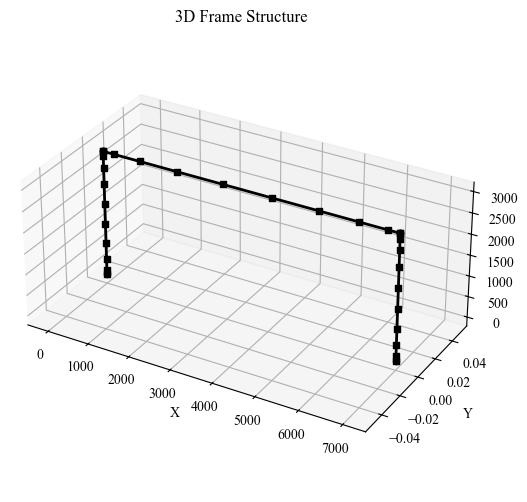

In [3]:
frame = Frame(column            = column, 
			  beam              = column, 
			  number_of_stories = 1, 
			  story_height      = 3000, 
			  story_width       = 7000,
			  load_DOFs         = [12],
			  nodal_loads       = [1],
			  number_of_sections_per_element = 10)

plot_initial_structure(frame)

## Solver

In [4]:
non_linear_solver = Nonlinear(frame, constraint="Load")

In [5]:
increments = np.zeros(140)
increments.fill(5000)

u_history, lambda_history, section_forces, section_strains = non_linear_solver.solve(increments)

  0%|          | 0/140 [00:00<?, ?it/s]

----------------------------------------------
Load step 1 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  2.3428007491026083e-09
NR Converged!
----------------------------------------------
Load step 2 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  2.8062904113499834e-09
NR Converged!
----------------------------------------------
Load step 3 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  1.8812088862791056e-09
NR Conver

## Load Displacement Curve

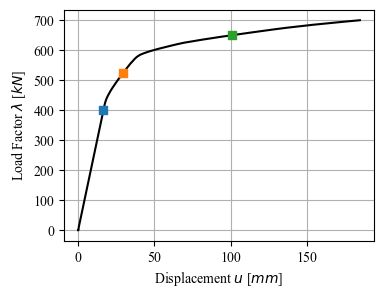

In [6]:
import matplotlib.pyplot as plt

# Main figure and axes
fig, ax = plt.subplots(figsize=(4, 3))
plt.rcParams["font.family"] = "Times New Roman"


ax.plot(u_history[:,12], lambda_history/1000,   label="Frame", color='k')

# plot the corresponding points to the figure of the below
ax.scatter(u_history[:,12][80], lambda_history[80]/1000, color='C0', s=30, zorder=5, marker='s')
ax.scatter(u_history[:,12][105], lambda_history[105]/1000, color='C1', s=30, zorder=5, marker='s')
ax.scatter(u_history[:,12][130], lambda_history[130]/1000, color='C2', s=30, zorder=5, marker='s')

ax.set_xlabel("Displacement $u$ [$mm$]")
ax.set_ylabel("Load Factor $\\lambda$ [$kN$]")
ax.grid()
plt.show()

## Section Forces and Curvature

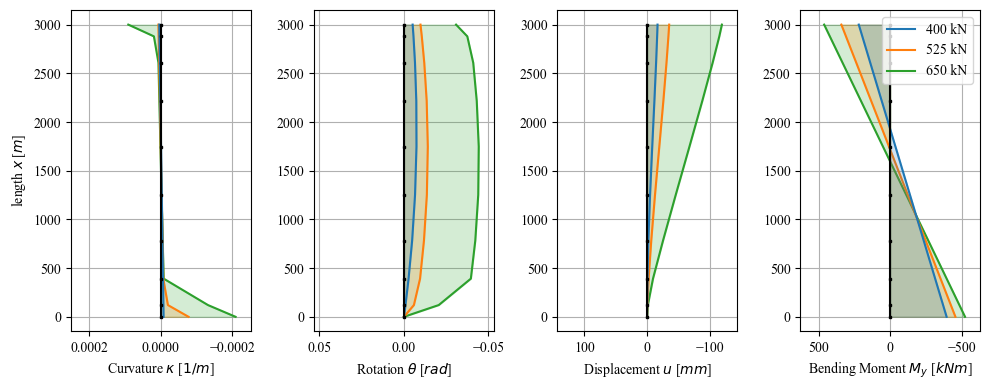

In [7]:
steps = [80, 105, 130]
plot_moments(steps, section_forces, section_strains, non_linear_solver, length=3000)

## Cross Section Analysis
___

### Setup Analysis

In [8]:
Analysis = stress_strain_analysis(column)

### Apply some given strains

N  = 0.00 kN
My = 387.16 kNm
Mz = 20.90 kNm


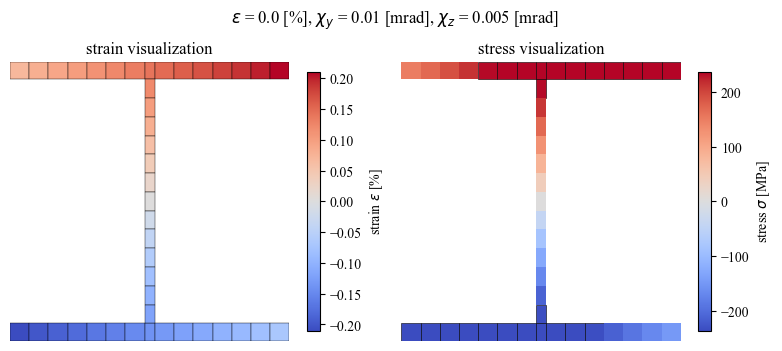

In [9]:
eps_x, chi_y, chi_z = 0.00, 0.00001, 0.000005

N, My, Mz = Analysis.get_section_forces(eps_x, chi_y, chi_z)

print("N  = {:.2f} kN".format(N))
print("My = {:.2f} kNm".format(My))
print("Mz = {:.2f} kNm".format(Mz))

plot_stress_strain_steel(Analysis)

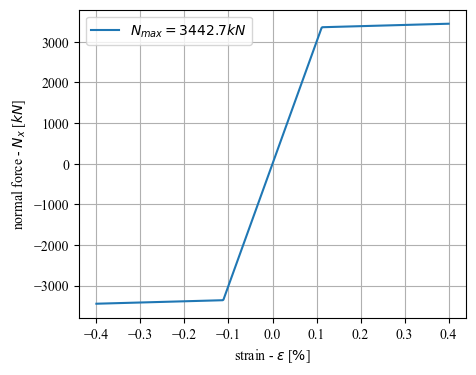

In [10]:
strains = np.linspace(-0.004, 0.004, 500)
plot_linear_variation_eps(Analysis, strains)

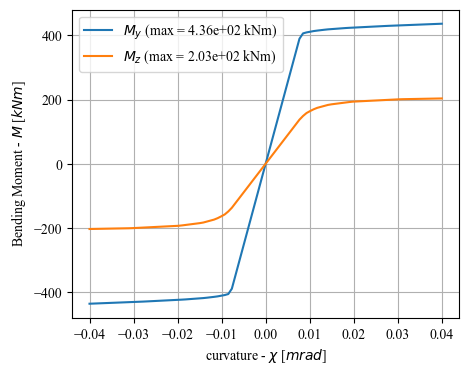

In [11]:
curvs = np.linspace(-0.00004, 0.00004, 100)
plot_linear_variation_curv(Analysis, curvs)

### Apply some given section forces

eps_x = 4.92e-04
chi_y = 6.08e-06
chi_z = -2.31e-20


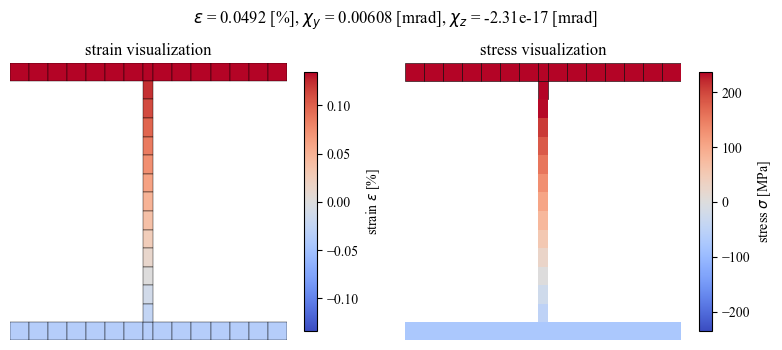

In [12]:
from math import log10, floor
def round_to_significant(x):
	return round(x, -int(floor(log10(abs(x/100)))))

N  = 1200 # kN
My = 270 # kNm
Mz = 0   # kNm

eps_x, chi_y, chi_z = Analysis.get_strain_and_curvatures(N, My, Mz)

eps_x, chi_y, chi_z = round_to_significant(eps_x), round_to_significant(chi_y), round_to_significant(chi_z)

print("eps_x = {:.2e}".format(eps_x))
print("chi_y = {:.2e}".format(chi_y))
print("chi_z = {:.2e}".format(chi_z))


Analysis.set_strain_and_curvature(eps_x, chi_y, chi_z)
plot_stress_strain_steel(Analysis)

### $N-M$ and $M_y-M_z$ influence plots

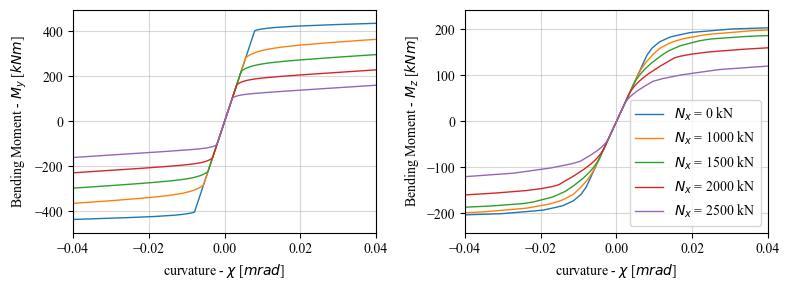

In [13]:
N = [0, 1000, 1500, 2000, 2500]
My_lim = [-450, 450]
Mz_lim = [-220, 220]
plot_influence_of_N_on_M(Analysis, N, My_lim, Mz_lim)

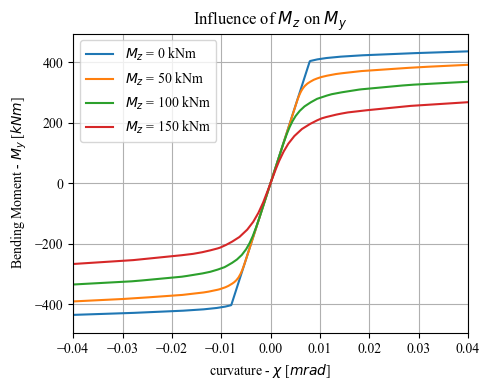

In [14]:
Mz = [0, 50, 100, 150]
My_lim = [-450, 450]
plot_influence_of_Mz_on_My(Analysis, My_lim, Mz)

### $N-M$ and $M_y-M_z$ interaction plots

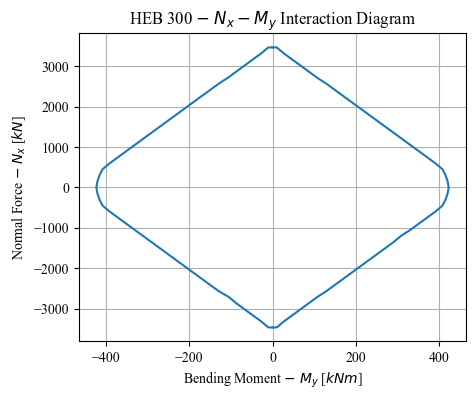

In [15]:
My = np.linspace(-450, 450, 361)
M_min = [0]
M_max = [0]

# Find N_min and N_max
N = np.linspace(0, 4000, 2001)
N_max = 0

def each_fiber_yielding():
	# Check if each fiber is yielding
	counter = 0
	for stress in Analysis.stresses:
		if np.abs(stress) < 243:
			counter += 1
	return (counter == 0) or (abs(Analysis.xsi_y) >= 0.00002) or (abs(Analysis.xsi_z) >= 0.00002)

for i, N_target in enumerate(N):
	initial_guess = [0.0, 0.0, 0.0]
	result = fsolve(Analysis.system_of_equations, initial_guess, args=(N_target, 0, 0), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		if each_fiber_yielding():
			pass
		else:
			N_max = N_target

N_solutions = [-N_max]
N = np.linspace(-N_max, N_max, 47)

for i, N_target in enumerate(N):
	M_res = []
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(Analysis.system_of_equations, initial_guess, args=(N_target, target_M, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			if each_fiber_yielding():
				pass
			else:
				M_res.append(M)
	if len(M_res) > 0:
		# Append the minimum and maximum M values for the current N
		# Check if M_res is not empty before appending
		M_min.append(min(M_res))
		M_max.append(max(M_res))
		N_solutions.append(N_target)

M_min.append(0)
M_max.append(0)
N_solutions.append(N_max)

# Plotting the results
plt.figure(figsize=(5, 4))
plt.plot(M_min, N_solutions,linestyle='-', color='C0')
plt.plot(M_max, N_solutions,linestyle='-', color='C0')
plt.grid()
plt.xlabel('Bending Moment $-$ $M_y$ [$kNm$]')
plt.ylabel('Normal Force $-$ $N_x$ [$kN$]')
plt.title('HEB 300 $-$ $N_x-M_y$ Interaction Diagram')
plt.show()


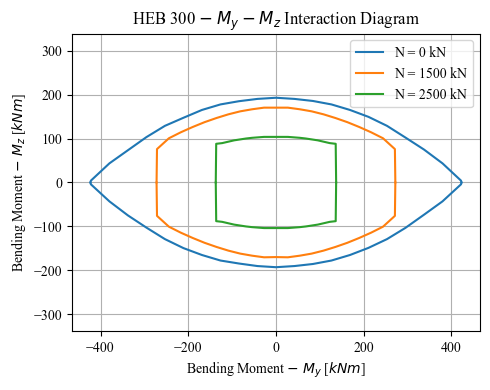

In [16]:
plt.figure(figsize=(5, 4))
c = ['C0', 'C1', 'C2']

for i, N_target in enumerate([0, 1500, 2500]):
	Mz_range = np.linspace(-210, 210, 801)

	Mz_neg = [0]
	Mz_pos = [0]

	# Find My_min and My_max
	My = np.linspace(0, 450, 201)

	for My_target in My:
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(Analysis.system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			if each_fiber_yielding():
				pass
			else:
				My_max = My_target

	My_sol = [-My_max]
	
	My_range = np.linspace(-My_max+1, My_max-1, 21)

	for My in My_range:
		Mz_success = []
		for Mz in Mz_range:
			initial_guess = [0.0, 0.0, 0.0]
			result = fsolve(Analysis.system_of_equations, initial_guess, args=(N_target, My, Mz), full_output=1)
			if result[2] == 1:
				if each_fiber_yielding():
					pass
				else:
					Mz_success.append(Mz)
		if len(Mz_success) > 0:
			My_sol.append(My)
			Mz_neg.append(min(Mz_success))
			Mz_pos.append(max(Mz_success))
	
	My_sol.append(My_max)
	Mz_neg.append(0)
	Mz_pos.append(0)

	plt.plot(My_sol, Mz_neg, color=c[i])
	plt.plot(My_sol, Mz_pos, color=c[i], label=f"N = {N_target} kN")


plt.xlabel("Bending Moment $-$ $M_y$ [$kNm$]")
plt.ylabel("Bending Moment $-$ $M_z$ [$kNm$]")
plt.title("HEB 300 $-$ $M_y-M_z$ Interaction Diagram")
plt.grid()
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()